In [1]:
# Load data ke dalam data frame 
import pandas as pd

# spesifikasi encoding diperlukan karena data tidak menggunakan UTF-8
df = pd.read_csv('sentimen_150_terpisah.csv', encoding='latin-1') 

df.head()

,review_tokens_stemmed,sentimen,classified_text,tweet_text,sentence_score,max_positive,max_negative,kelas
0,beautiful package bintang buat safety nya,{'classified_text': 'beautiful package bintang...,beautiful package bintang buat safety nya,beautiful package bintang buat safety nya,['beautiful package bintang buat safety nya'],1,-1,netral
1,tipe kulit kering,"{'classified_text': 'tipe kulit kering', 'twee...",tipe kulit kering,tipe kulit kering,['tipe kulit kering'],1,-1,netral
2,kirim lama beda provinsi gapapa packingnya ama...,{'classified_text': 'kirim lama [-2] beda prov...,kirim lama [-2] beda provinsi gapapa packingny...,kirim lama beda provinsi gapapa packingnya am...,['kirim lama [-2] beda provinsi gapapa packing...,5,-2,positif
3,top,"{'classified_text': 'top [4]', 'tweet_text': '...",top [4],top,['top [4]'],4,-1,positif
4,tipe kulit minyak tipe kulit kering tipe kulit...,{'classified_text': 'tipe kulit minyak tipe ku...,tipe kulit minyak tipe kulit kering tipe kulit...,tipe kulit minyak tipe kulit kering tipe kuli...,['tipe kulit minyak tipe kulit kering tipe kul...,3,-5,negatif


In [2]:
# Drop 3 kolom terakhir yang tidak digunakan dengan fungsi iloc
df = df.drop(df.iloc[:,1:7], axis=1)

# Cek data teratas
df.head()

,review_tokens_stemmed,kelas
0,beautiful package bintang buat safety nya,netral
1,tipe kulit kering,netral
2,kirim lama beda provinsi gapapa packingnya ama...,positif
3,top,positif
4,tipe kulit minyak tipe kulit kering tipe kulit...,negatif


In [3]:
# Data untuk rename kolom v1 dan v2
new_cols = {
    'review_tokens_stemmed' : 'Review',
    'kelas' : 'Sentimen'
}

# Rename nama kolom v1 dan v2
df = df.rename(columns=new_cols)

# Cek data teratas
df.head()

,Review,Sentimen
0,beautiful package bintang buat safety nya,netral
1,tipe kulit kering,netral
2,kirim lama beda provinsi gapapa packingnya ama...,positif
3,top,positif
4,tipe kulit minyak tipe kulit kering tipe kulit...,negatif


In [4]:
# Cek jumlah data per kelas
print(df['Sentimen'].value_counts())
print('\n')

# Cek kelengkapan data
print(df.info())
print('\n')

# Cek statistik deskriptif
print(df.describe())

positif    92
netral     29
negatif    14
Name: Sentimen, dtype: int64


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 135 entries, 0 to 134
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Review    135 non-null    object
 1   Sentimen  135 non-null    object
dtypes: object(2)
memory usage: 2.2+ KB
None


       Review Sentimen
count     135      135
unique    130        3
top     bagus  positif
freq        3       92


In [5]:
# Data untuk label
new_labels = {
    'negatif' : 0,
    'netral' : 1,
    'positif' : 2
}

# Encode label (mengubah label dari spam dan ham menjadi 1 dan 0)
df['Sentimen'] = df['Sentimen'].map(new_labels)

# Cek data teratas
df.head()

,Review,Sentimen
0,beautiful package bintang buat safety nya,1
1,tipe kulit kering,1
2,kirim lama beda provinsi gapapa packingnya ama...,2
3,top,2
4,tipe kulit minyak tipe kulit kering tipe kulit...,0


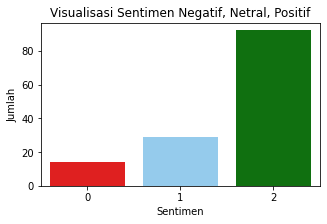

In [6]:
import seaborn as sns
import matplotlib.pyplot as plt

# visualisasi sentimen positif, netral, dan negatif
plt.figure(figsize=(5, 3))
sns.countplot(data=df, x='Sentimen', palette={0: 'red', 1: 'lightskyblue', 2: 'green'})
plt.title('Visualisasi Sentimen Negatif, Netral, Positif')
plt.xlabel('Sentimen')
plt.ylabel('Jumlah')
plt.show()

In [7]:
# Memisahkan fitur dengan label
X = df['Review'].values
y = df['Sentimen'].values

In [8]:
# Ekstraksi fitur
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix
from imblearn.over_sampling import SMOTE

# Inisialisasi model
mnb = MultinomialNB()

# Membuat objek StratifiedKFold untuk 10-fold cross-validation
skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

# Inisialisasi TfidfVectorizer
bow = TfidfVectorizer(max_features=510)

# List untuk menyimpan prediksi dan label sebenarnya dari setiap lipatan
all_predictions = []
all_true_labels = []

# Loop melalui setiap lipatan (fold) dalam cross-validation
for train_index, test_index in skf.split(X, y):
    X_train, X_test = X[train_index], X[test_index]  # Data latih dan uji
    y_train, y_test = y[train_index], y[test_index]  # Label data latih dan uji

    # Transformasi seluruh data menggunakan TfidfVectorizer
    X_train_transform = bow.fit_transform(X_train)
    X_test_transform = bow.transform(X_test)

    # Melatih model klasifikasi pada data latih
    mnb.fit(X_train_transform, y_train)

    # Membuat prediksi pada data uji
    predictions = mnb.predict(X_test_transform)

    # Menambahkan prediksi dan label sebenarnya ke dalam list
    all_predictions.extend(predictions)
    all_true_labels.extend(y_test)

In [9]:
# Hitung metrik evaluasi
accuracy = accuracy_score(all_true_labels, all_predictions)
precision = precision_score(all_true_labels, all_predictions, average='weighted')
recall = recall_score(all_true_labels, all_predictions, average='weighted')
f1 = f1_score(all_true_labels, all_predictions, average='weighted')

# Print hasil
print("Overall accuracy:", accuracy)
print("Overall precision:", precision)
print("Overall recall:", recall)
print("Overall F1-score:", f1)

print(f'Confusion Matrix : \n {confusion_matrix(all_true_labels, all_predictions)}')
print('-----------------------------------------------------\n')
print(classification_report(all_true_labels, all_predictions, zero_division=0))

Overall accuracy: 0.7111111111111111
Overall precision: 0.5823013853548205
Overall recall: 0.7111111111111111
Overall F1-score: 0.6083891564708706
Confusion Matrix : 
 [[ 4  0 10]
 [ 0  0 29]
 [ 0  0 92]]
-----------------------------------------------------

              precision    recall  f1-score   support

           0       1.00      0.29      0.44        14
           1       0.00      0.00      0.00        29
           2       0.70      1.00      0.83        92

    accuracy                           0.71       135
   macro avg       0.57      0.43      0.42       135
weighted avg       0.58      0.71      0.61       135



c:\Users\NISRINA\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [13]:
new_text = input("\nMasukkan teks baru: ")
new_text_vec = bow.transform([new_text])
predicted_sentimen = mnb.predict(new_text_vec)

if predicted_sentimen[0] == 0:
    sentiment_label = "negatif"
elif predicted_sentimen[0] == 1:
    sentiment_label = "netral"
elif predicted_sentimen[0] == 2:
    sentiment_label = "positif"

print("Hasil Analisis Sentimen untuk Teks Baru : ", sentiment_label)

Hasil Analisis Sentimen untuk Teks Baru :  positif
